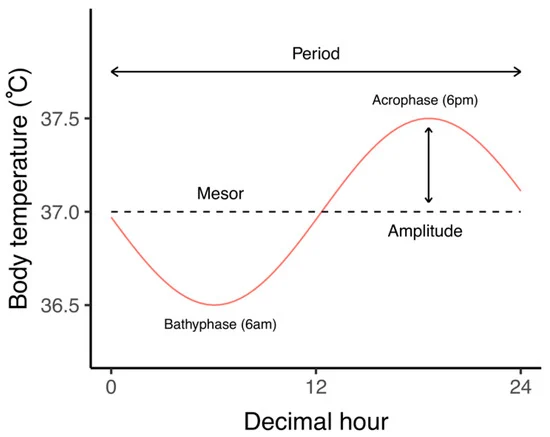

In [59]:
from PIL import Image
from IPython.display import display

image = Image.open("/home/coldrand/pyTBI-data/data/biology-10-00065-g002-550.webp")
display(image)


## MESOR considering 12 days, TBI - 6 and TBI + 6

Metadata Loaded:
   animal group probe_ID probe_implant_date probe_implant_time   tbi_date  \
0       1  Sham  1 N8862           5/2/2023              14:34 2023-05-16   
1       2   TBI    N7779           2/2/2023              14:10 2023-02-16   
2       3   TBI    N7788           2/2/2023              14:36 2023-02-16   
3       4  Sham    N7784           2/2/2023              17:05 2023-02-16   
4       5  Sham    N7786           2/2/2023              17:34 2023-02-16   

  tbi_time cold_challenge_date cold_challenge_start cold_challenge_end  exp  
0    15:12           5/23/2023                 9:30              15:30    4  
1    15:12           2/23/2023                 9:30              15:30    3  
2    15:12           2/23/2023                10:00              16:00    3  
3    15:12           2/23/2023                 9:30              15:30    3  
4    15:12           2/23/2023                10:00              16:00    3  
TBI animals: [2, 3, 6, 7, 8]
Sham animals: [1, 4, 5,

/tmp/ipykernel_333/1779640130.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_333/1779640130.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['date_time'])
/tmp/ipykernel_333/1779640130.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Results found, proceeding to plot.


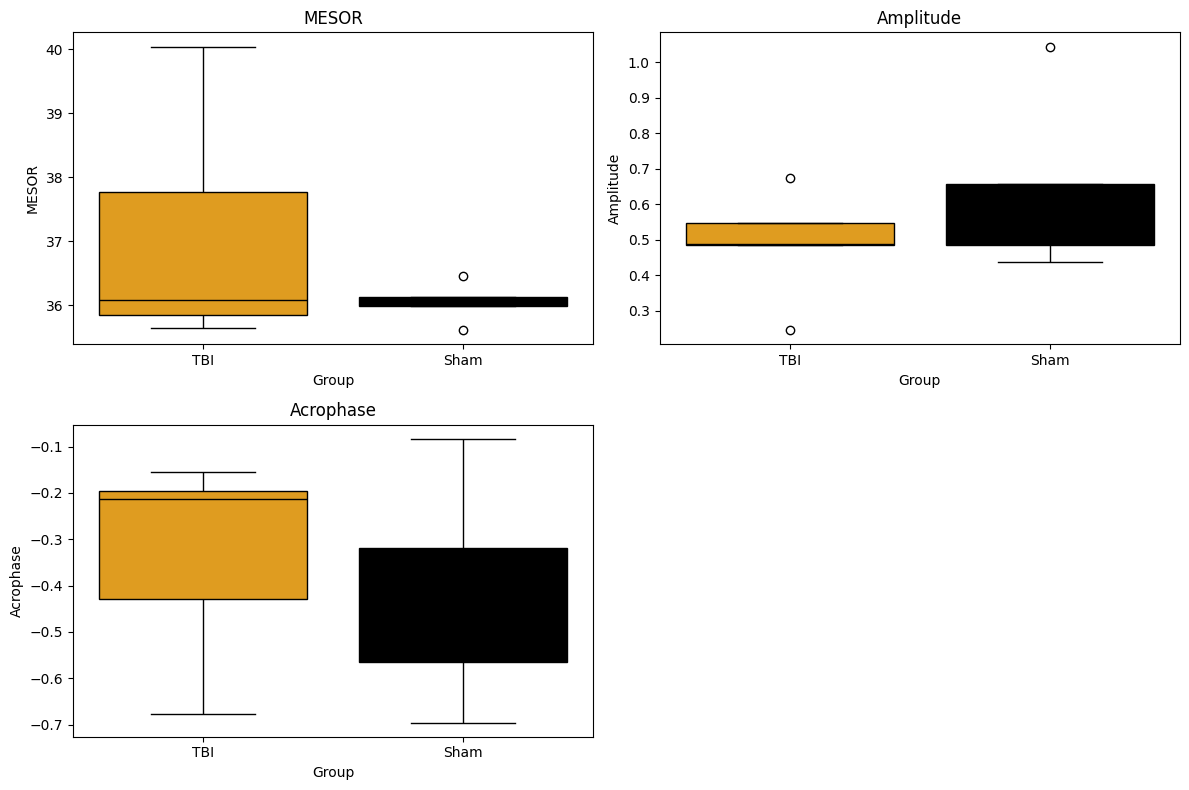

/tmp/ipykernel_333/1779640130.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
/tmp/ipykernel_333/1779640130.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
/tmp/ipykernel_333/1779640130.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)


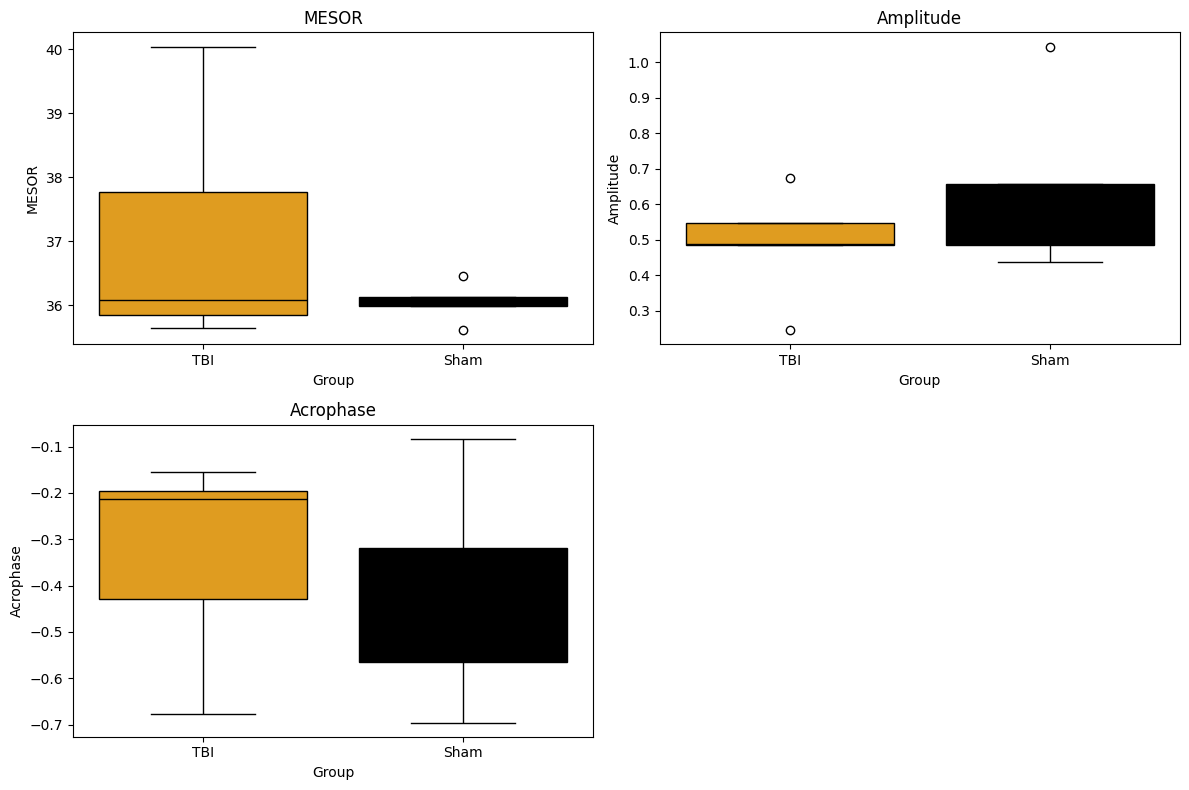

In [9]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from statsmodels.formula.api import mixedlm

# Function to read paths from a text file
def read_paths(file_path):
    paths = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            paths[key] = value
    return paths

# Load the paths from the text file
paths = read_paths('paths.txt')

# Load the metadata
metadata = pd.read_csv(paths['metadata_path'], parse_dates=['tbi_date'])

# Handle duplicates by taking the first occurrence for each animal
metadata = metadata.groupby('animal').first().reset_index()

# Verify that metadata is loaded correctly
print("Metadata Loaded:")
print(metadata.head())

# Extract TBI and Sham animal lists from the metadata
tbi_animals = metadata[metadata['group'] == 'TBI']['animal'].tolist()
sham_animals = metadata[metadata['group'] == 'Sham']['animal'].tolist()

# Print the list of animals for verification
print(f"TBI animals: {tbi_animals}")
print(f"Sham animals: {sham_animals}")

# Create a dictionary to map each animal to its group and TBI date
animal_info = metadata.set_index('animal')[['group', 'tbi_date']].to_dict('index')

# Folder path for experiment data
folder_path = paths['folder_path']

# Load experiment data and exclude specified pairs
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))
temperature_data = {}

# Iterate over all files and load them into temperature_data
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    animal_exp = file_name.replace('bruna', '').replace('.xlsx', '')
    animal, exp = map(int, animal_exp.split('_'))
    
    if animal not in temperature_data:
        temperature_data[animal] = {}
    
    df = pd.read_excel(file_path)
    temperature_data[animal][exp] = df

# Function to trim data
def trim_data(data, tbi_date=None, days_before=6, days_after=6, temp_min=34, temp_max=39):
    if tbi_date:
        start_date = tbi_date - pd.Timedelta(days=days_before)
        end_date = tbi_date + pd.Timedelta(days=days_after)
    else:
        in_range = data[(data['temp'] >= temp_min) & (data['temp'] <= temp_max)]
        if in_range.empty:
            print("No data found within the specified temperature range.")
            return pd.DataFrame()
        start_date = in_range['date_time'].iloc[0]
        end_date = in_range['date_time'].iloc[-1]

    trimmed_data = data[(data['date_time'] >= start_date) & (data['date_time'] <= end_date)]
    return trimmed_data

# Cosinor model function
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# Perform Cosinor Analysis and save results
def perform_cosinor_analysis(group_data, animal_info):
    results = {'animal': [], 'group': [], 'experiment': [], 'Mesor': [], 'Amplitude': [], 'Acrophase': []}
    for animal, experiments in group_data.items():
        animal_group = animal_info[animal]['group']
        tbi_date = animal_info[animal]['tbi_date']
        for exp, data in experiments.items():
            data = trim_data(data, tbi_date)

            if data.empty:
                continue

            data['time'] = pd.to_datetime(data['date_time'])
            time_in_minutes = (data['time'] - data['time'].min()).dt.total_seconds() / 60
            time_in_hours = time_in_minutes / 60
            temperature = data['temp'].values

            if len(temperature) == 0:
                continue

            guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]

            try:
                params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
                mesor, amplitude, acrophase = params

                results['animal'].append(animal)
                results['group'].append(animal_group)
                results['experiment'].append(exp)
                results['Mesor'].append(mesor)
                results['Amplitude'].append(amplitude)
                results['Acrophase'].append(acrophase)

            except RuntimeError as e:
                print(f"Curve fitting failed for animal {animal} experiment {exp}: {e}")
                continue

    return pd.DataFrame(results)

# Declare tbi_group_data and sham_group_data based on the lists from the metadata
tbi_group_data = {animal: temperature_data[animal] for animal in tbi_animals if animal in temperature_data}
sham_group_data = {animal: temperature_data[animal] for animal in sham_animals if animal in temperature_data}

# Perform the analysis
tbi_results = perform_cosinor_analysis(tbi_group_data, animal_info)
sham_results = perform_cosinor_analysis(sham_group_data, animal_info)

# Combine the results
all_results = pd.concat([tbi_results, sham_results])

# Check if there are any results
if all_results.empty:
    print("No results available to plot.")
else:
    print("Results found, proceeding to plot.")
    # Visualization
    plt.figure(figsize=(12, 8))

    # Define the color palette
    palette = {'Sham': 'black', 'TBI': 'orange'}

    # MESOR plot
    plt.subplot(2, 2, 1)
    sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
    plt.title('MESOR')
    plt.xlabel('Group')
    plt.ylabel('MESOR')

    # Amplitude plot
    plt.subplot(2, 2, 2)
    sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
    plt.title('Amplitude')
    plt.xlabel('Group')
    plt.ylabel('Amplitude')

    # Acrophase plot
    plt.subplot(2, 2, 3)
    sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)
    plt.title('Acrophase')
    plt.xlabel('Group')
    plt.ylabel('Acrophase')

    plt.tight_layout()
    plt.show()

    # Save the results to a PDF, TIFF, and SVG
    pdf_filename = 'cosinor_group_comparison.pdf'
    tiff_filename = 'cosinor_group_comparison.tiff'
    svg_filename = 'cosinor_group_comparison.svg'

    with PdfPages(pdf_filename) as pdf:
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        sns.boxplot(x='group', y='Mesor', data=all_results, palette=palette)
        plt.title('MESOR')
        plt.xlabel('Group')
        plt.ylabel('MESOR')
        
        plt.subplot(2, 2, 2)
        sns.boxplot(x='group', y='Amplitude', data=all_results, palette=palette)
        plt.title('Amplitude')
        plt.xlabel('Group')
        plt.ylabel('Amplitude')
        
        plt.subplot(2, 2, 3)
        sns.boxplot(x='group', y='Acrophase', data=all_results, palette=palette)
        plt.title('Acrophase')
        plt.xlabel('Group')
        plt.ylabel('Acrophase')
        
        plt.tight_layout()
        pdf.savefig()
        plt.savefig(tiff_filename, format='tiff', dpi=300)
        plt.savefig(svg_filename, format='svg')
    
    plt.show()


# MESOR split in two groups: TBI-6days and TBI+6days

In [17]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# Function to read paths from a text file
def read_paths(file_path):
    paths = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            paths[key] = value
    return paths

# Load the paths from the text file
paths = read_paths('paths.txt')

# Load the metadata
metadata = pd.read_csv(paths['metadata_path'], parse_dates=['tbi_date'])

# Handle duplicates by taking the first occurrence for each animal
metadata = metadata.groupby('animal').first().reset_index()

# Extract TBI and Sham animal lists from the metadata
tbi_animals = metadata[metadata['group'] == 'TBI']['animal'].tolist()
sham_animals = metadata[metadata['group'] == 'Sham']['animal'].tolist()

# Create a dictionary to map each animal to its group and TBI date
animal_info = metadata.set_index('animal')[['group', 'tbi_date']].to_dict('index')

# Folder path for experiment data
folder_path = paths['folder_path']

# Load experiment data
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))
temperature_data = {}

# Iterate over all files and load them into temperature_data
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    animal_exp = file_name.replace('bruna', '').replace('.xlsx', '')
    animal, exp = map(int, animal_exp.split('_'))
    
    if animal not in temperature_data:
        temperature_data[animal] = {}
    
    df = pd.read_excel(file_path)
    temperature_data[animal][exp] = df

# Function to split data into TBI-6days and TBI+6days
def split_data(data, tbi_date, days=6):
    pre_tbi_start = tbi_date - pd.Timedelta(days=days)
    pre_tbi_end = tbi_date
    post_tbi_start = tbi_date
    post_tbi_end = tbi_date + pd.Timedelta(days=days)
    
    pre_tbi_data = data[(data['date_time'] >= pre_tbi_start) & (data['date_time'] < pre_tbi_end)]
    post_tbi_data = data[(data['date_time'] >= post_tbi_start) & (data['date_time'] <= post_tbi_end)]
    
    return pre_tbi_data, post_tbi_data

# Cosinor model function
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# Perform Cosinor Analysis and save results split by TBI-6days and TBI+6days
def perform_cosinor_analysis_split(group_data, animal_info):
    results = {
        'animal': [], 'group': [], 'experiment': [], 
        'Mesor_PreTBI': [], 'Amplitude_PreTBI': [], 'Acrophase_PreTBI': [],
        'Mesor_PostTBI': [], 'Amplitude_PostTBI': [], 'Acrophase_PostTBI': []
    }
    
    for animal, experiments in group_data.items():
        animal_group = animal_info[animal]['group']
        tbi_date = animal_info[animal]['tbi_date']
        
        for exp, data in experiments.items():
            pre_tbi_data, post_tbi_data = split_data(data, tbi_date)
            
            # Pre-TBI Analysis
            if not pre_tbi_data.empty:
                pre_tbi_data['time'] = pd.to_datetime(pre_tbi_data['date_time'])
                time_in_minutes = (pre_tbi_data['time'] - pre_tbi_data['time'].min()).dt.total_seconds() / 60
                time_in_hours = time_in_minutes / 60
                temperature = pre_tbi_data['temp'].values
                
                guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]
                
                try:
                    params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
                    mesor, amplitude, acrophase = params
                except RuntimeError as e:
                    print(f"Curve fitting failed for animal {animal} experiment {exp} Pre-TBI: {e}")
                    mesor, amplitude, acrophase = np.nan, np.nan, np.nan
                
                results['Mesor_PreTBI'].append(mesor)
                results['Amplitude_PreTBI'].append(amplitude)
                results['Acrophase_PreTBI'].append(acrophase)
            else:
                results['Mesor_PreTBI'].append(np.nan)
                results['Amplitude_PreTBI'].append(np.nan)
                results['Acrophase_PreTBI'].append(np.nan)
            
            # Post-TBI Analysis
            if not post_tbi_data.empty:
                post_tbi_data['time'] = pd.to_datetime(post_tbi_data['date_time'])
                time_in_minutes = (post_tbi_data['time'] - post_tbi_data['time'].min()).dt.total_seconds() / 60
                time_in_hours = time_in_minutes / 60
                temperature = post_tbi_data['temp'].values
                
                guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]
                
                try:
                    params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
                    mesor, amplitude, acrophase = params
                except RuntimeError as e:
                    print(f"Curve fitting failed for animal {animal} experiment {exp} Post-TBI: {e}")
                    mesor, amplitude, acrophase = np.nan, np.nan, np.nan
                
                results['Mesor_PostTBI'].append(mesor)
                results['Amplitude_PostTBI'].append(amplitude)
                results['Acrophase_PostTBI'].append(acrophase)
            else:
                results['Mesor_PostTBI'].append(np.nan)
                results['Amplitude_PostTBI'].append(np.nan)
                results['Acrophase_PostTBI'].append(np.nan)
            
            # Common entries
            results['animal'].append(animal)
            results['group'].append(animal_group)
            results['experiment'].append(exp)

    return pd.DataFrame(results)

# Declare tbi_group_data and sham_group_data based on the lists from the metadata
tbi_group_data = {animal: temperature_data[animal] for animal in tbi_animals if animal in temperature_data}
sham_group_data = {animal: temperature_data[animal] for animal in sham_animals if animal in temperature_data}

# Perform the analysis split by TBI-6days and TBI+6days
tbi_results = perform_cosinor_analysis_split(tbi_group_data, animal_info)
sham_results = perform_cosinor_analysis_split(sham_group_data, animal_info)

# Combine the results
all_results = pd.concat([tbi_results, sham_results])

# Check for duplicates in the DataFrame
if all_results.index.duplicated().any():
    print("Duplicate indices found. Removing duplicates.")
    all_results = all_results[~all_results.index.duplicated(keep='first')]

# Alternatively, reset the index if duplicates are not in the index but in the data
all_results = all_results.reset_index(drop=True)

# Check if there are any results after cleaning
if all_results.empty:
    print("No results available to plot.")
else:
    print("Results found, proceeding to plot.")
    
    # Create a PdfPages object to save all plots into a single PDF
    with PdfPages('cosinor_group_comparison_split.pdf') as pdf:
        # Define the color palette
        palette = {'Sham': 'black', 'TBI': 'orange'}

        # MESOR Pre-TBI plot
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='group', y='Mesor_PreTBI', data=all_results, palette=palette)
        plt.title('MESOR (TBI-6days)')
        plt.xlabel('Group')
        plt.ylabel('MESOR (Pre-TBI)')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()    # closes the figure

        # MESOR Post-TBI plot
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='group', y='Mesor_PostTBI', data=all_results, palette=palette)
        plt.title('MESOR (TBI+6days)')
        plt.xlabel('Group')
        plt.ylabel('MESOR (Post-TBI)')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()    # closes the figure

    print("Plots saved to PDF successfully.")


/tmp/ipykernel_333/3462651965.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_tbi_data['time'] = pd.to_datetime(pre_tbi_data['date_time'])
/tmp/ipykernel_333/3462651965.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_tbi_data['time'] = pd.to_datetime(post_tbi_data['date_time'])
/tmp/ipykernel_333/3462651965.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Duplicate indices found. Removing duplicates.
Results found, proceeding to plot.
Plots saved to PDF successfully.


/tmp/ipykernel_333/3462651965.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='Mesor_PostTBI', data=all_results, palette=palette)


# Senoids comparison

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os

# Cosinor model function
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# Function to trim the data based on a time window around the TBI date
def trim_data(data, tbi_date, days_before=0, days_after=0):
    start_date = tbi_date - pd.Timedelta(days=days_before)
    end_date = tbi_date + pd.Timedelta(days=days_after)
    return data[(data['date_time'] >= start_date) & (data['date_time'] <= end_date)]

# Function to read paths from a text file
def read_paths(file_path):
    paths = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            paths[key.strip()] = value.strip()
    return paths

# Function to calculate and plot Cosinor parameters for a given group
def calculate_and_plot_cosinor(temperature_data, animal_info, group_name):
    def prepare_data(data, tbi_date, window):
        if window == 'before':
            trimmed_data = trim_data(data, tbi_date, days_before=6)
        elif window == 'after':
            trimmed_data = trim_data(data, tbi_date, days_after=6)
        if not trimmed_data.empty:
            trimmed_data['time_in_hours'] = (trimmed_data['date_time'] - trimmed_data['date_time'].min()).dt.total_seconds() / 3600
            return trimmed_data['time_in_hours'].values, trimmed_data['temp'].values
        else:
            return None, None

    def fit_cosinor(time, temp):
        if time is None or temp is None:
            return None, None, None, None
        guess = [temp.mean(), (temp.max() - temp.min()) / 2, 0]
        try:
            params, _ = curve_fit(cosinor_model, time, temp, p0=guess)
            mesor, amplitude, acrophase = params
            bathyphase = (acrophase + 12) % 24
            return mesor, amplitude, acrophase, bathyphase
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None, None, None

    # Initialize lists to hold results for all animals in the group
    time_before_all, temp_before_all = [], []
    time_after_all, temp_after_all = [], []
    labels_before, labels_after = [], []

    for animal, experiments in temperature_data.items():
        animal_group = animal_info[animal]['group']
        if animal_group != group_name:
            continue

        tbi_date = animal_info[animal]['tbi_date']
        for exp, data in experiments.items():
            time_before, temp_before = prepare_data(data, tbi_date, 'before')
            if time_before is not None:
                time_before_all.extend(time_before)
                temp_before_all.extend(temp_before)
                labels_before.append(f'{group_name} Animal {animal}, Exp {exp} (Before)')
            
            time_after, temp_after = prepare_data(data, tbi_date, 'after')
            if time_after is not None:
                time_after_all.extend(time_after)
                temp_after_all.extend(temp_after)
                labels_after.append(f'{group_name} Animal {animal}, Exp {exp} (After)')

    # Fit cosinor models for the combined data
    mesor_before, amplitude_before, acrophase_before, bathyphase_before = fit_cosinor(np.array(time_before_all), np.array(temp_before_all))
    mesor_after, amplitude_after, acrophase_after, bathyphase_after = fit_cosinor(np.array(time_after_all), np.array(temp_after_all))

    # Print the results
    if mesor_before is not None:
        print(f'{group_name} Before Period: Mesor={mesor_before:.2f}, Amplitude={amplitude_before:.2f}, Acrophase={acrophase_before:.2f}, Bathyphase={bathyphase_before:.2f}')
    if mesor_after is not None:
        print(f'{group_name} After Period: Mesor={mesor_after:.2f}, Amplitude={amplitude_after:.2f}, Acrophase={acrophase_after:.2f}, Bathyphase={bathyphase_after:.2f}')

    # Plotting the results
    time_points = np.linspace(0, 24, 1000)
    plt.figure(figsize=(10, 6))
    
    if mesor_before is not None:
        fitted_before = cosinor_model(time_points, mesor_before, amplitude_before, acrophase_before)
        plt.plot(time_points, fitted_before, label=f'{group_name} Before Period', color='blue')
        plt.axhline(mesor_before, color='blue', linestyle='--', label=f'Mesor Before Period')
        plt.axvline(acrophase_before, color='blue', linestyle=':', label=f'Acrophase Before Period')
    
    if mesor_after is not None:
        fitted_after = cosinor_model(time_points, mesor_after, amplitude_after, acrophase_after)
        plt.plot(time_points, fitted_after, label=f'{group_name} After Period', color='red')
        plt.axhline(mesor_after, color='red', linestyle='--', label=f'Mesor After Period')
        plt.axvline(acrophase_after, color='red', linestyle=':', label=f'Acrophase After Period')
    
    plt.title(f'Cosinor Fit for {group_name} Group Before and After Period')
    plt.xlabel('Time (hours)')
    plt.ylabel('Temperature')
    plt.legend()

    # Save the plot as TIFF and SVG
    tiff_filename = f'{group_name}_cosinor_plot.tiff'
    svg_filename = f'{group_name}_cosinor_plot.svg'
    plt.savefig(tiff_filename, format='tiff', dpi=300)
    plt.savefig(svg_filename, format='svg')

    plt.show()

    return tiff_filename, svg_filename

# Read paths from the paths.txt file
paths = read_paths('paths.txt')

# Load the metadata
metadata_path = paths['metadata_path']
metadata = pd.read_csv(metadata_path, parse_dates=['tbi_date'])

# Handle duplicates by taking the first occurrence for each animal
metadata = metadata.groupby('animal').first().reset_index()

# Extract animal info and temperature data
animal_info = metadata.set_index('animal')[['group', 'tbi_date']].to_dict('index')

# Load the experiment data (temperature_data should be populated as before)
# This assumes temperature_data is already populated as a dictionary of dataframes for each animal and experiment
folder_path = paths['folder_path']
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))
temperature_data = {}

for file_path in file_paths:
    file_name = os.path.basename(file_path)
    animal_exp = file_name.replace('bruna', '').replace('.xlsx', '')
    animal, exp = map(int, animal_exp.split('_'))
    
    if animal not in temperature_data:
        temperature_data[animal] = {}
    
    df = pd.read_excel(file_path)
    temperature_data[animal][exp] = df

# Execute the function to calculate and plot the Cosinor analysis for both TBI and Sham groups
sham_tiff, sham_svg = calculate_and_plot_cosinor(temperature_data, animal_info, 'Sham')
tbi_tiff, tbi_svg = calculate_and_plot_cosinor(temperature_data, animal_info, 'TBI')

# Print the generated file names
print(f'Sham TIFF: {sham_tiff}, Sham SVG: {sham_svg}')
print(f'TBI TIFF: {tbi_tiff}, TBI SVG: {tbi_svg}')


FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

# Data Export

In [74]:
# DataFrame for cosinor_group_comparison_plot (same as all_results)
df_cosinor_group_comparison_plot = all_results

# DataFrame for cosinor_group_comparison_before_after
df_cosinor_group_comparison_before_after = all_results[['animal', 'group', 'experiment', 'window', 'Mesor', 'Amplitude', 'Acrophase']]

# DataFrame for Sham_cosinor_plot
# Assuming the data comes from the calculation for the Sham group
sham_data_before_after = all_results[all_results['group'] == 'Sham']
df_sham_cosinor_plot = sham_data_before_after[['animal', 'experiment', 'Mesor', 'Amplitude', 'Acrophase']]

# DataFrame for TBI_cosinor_plot
# Assuming the data comes from the calculation for the TBI group
tbi_data_before_after = all_results[all_results['group'] == 'TBI']
df_tbi_cosinor_plot = tbi_data_before_after[['animal', 'experiment', 'Mesor', 'Amplitude', 'Acrophase']]

# Exporting to an Excel file
with pd.ExcelWriter('cosinor_analysis_data.xlsx', engine='xlsxwriter') as writer:
    df_cosinor_group_comparison_plot.to_excel(writer, sheet_name='group_comparison_plot', index=False)
    df_cosinor_group_comparison_before_after.to_excel(writer, sheet_name='comparison_before_after', index=False)
    df_sham_cosinor_plot.to_excel(writer, sheet_name='Sham_cosinor_plot', index=False)
    df_tbi_cosinor_plot.to_excel(writer, sheet_name='TBI_cosinor_plot', index=False)

print("Data has been exported to 'cosinor_analysis_data.xlsx'")


Data has been exported to 'cosinor_analysis_data.xlsx'
